<a href="https://colab.research.google.com/github/zainabzahara/Solar_Irradiance_Prediction/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pandas numpy matplotlib torch scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


<ipython-input-20-887af7b47cc5>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transformed_X[i, j, 0] = X[i, j]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100], Train Loss: 1.4211, Val Loss: 6.0979
Epoch [11/100], Train Loss: 0.5259, Val Loss: 0.5607
Epoch [21/100], Train Loss: 0.0527, Val Loss: 0.0843
Epoch [31/100], Train Loss: 0.0901, Val Loss: 0.0406
Epoch [41/100], Train Loss: 0.0406, Val Loss: 0.0339
Epoch [51/100], Train Loss: 0.0421, Val Loss: 0.0556
Epoch [61/100], Train Loss: 0.0319, Val Loss: 0.0385
Epoch [71/100], Train Loss: 0.0288, Val Loss: 0.0258
Epoch [81/100], Train Loss: 0.0269, Val Loss: 0.0222
Epoch [91/100], Train Loss: 0.0246, Val Loss: 0.0166


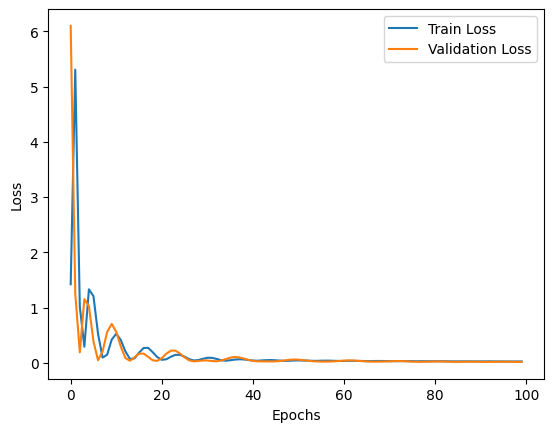

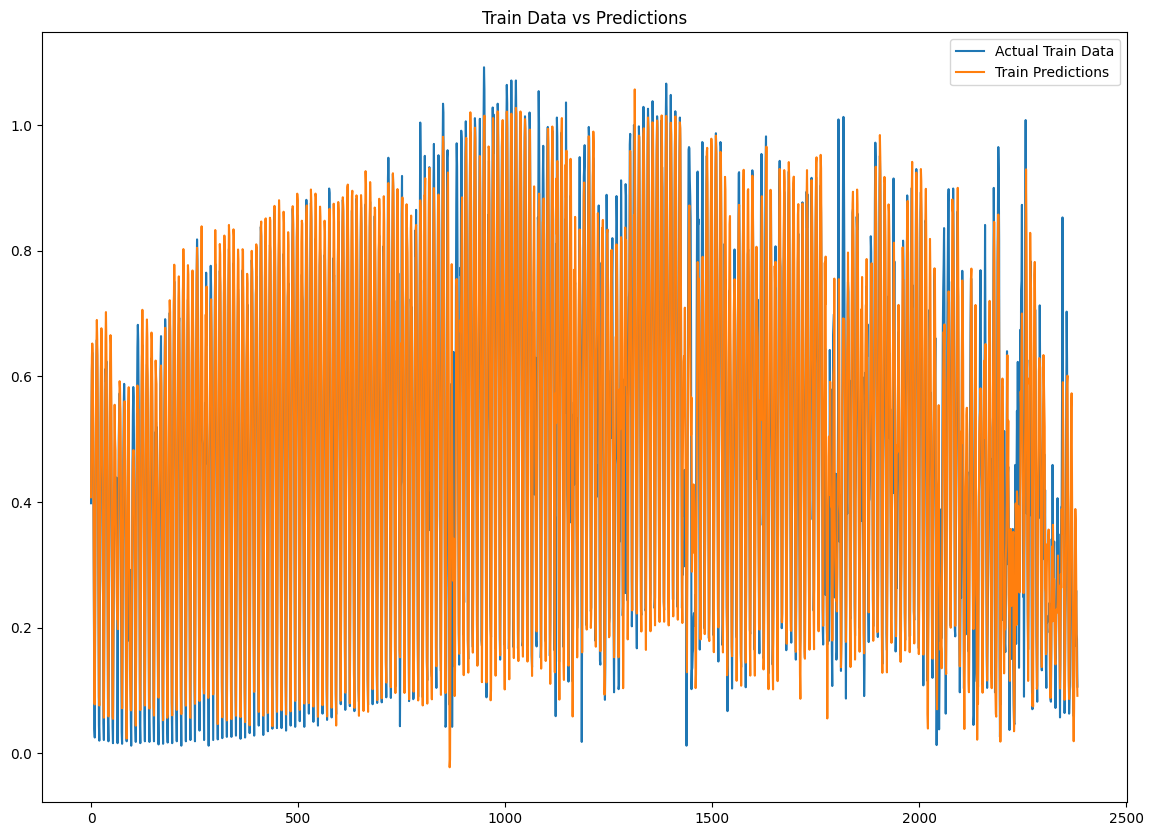

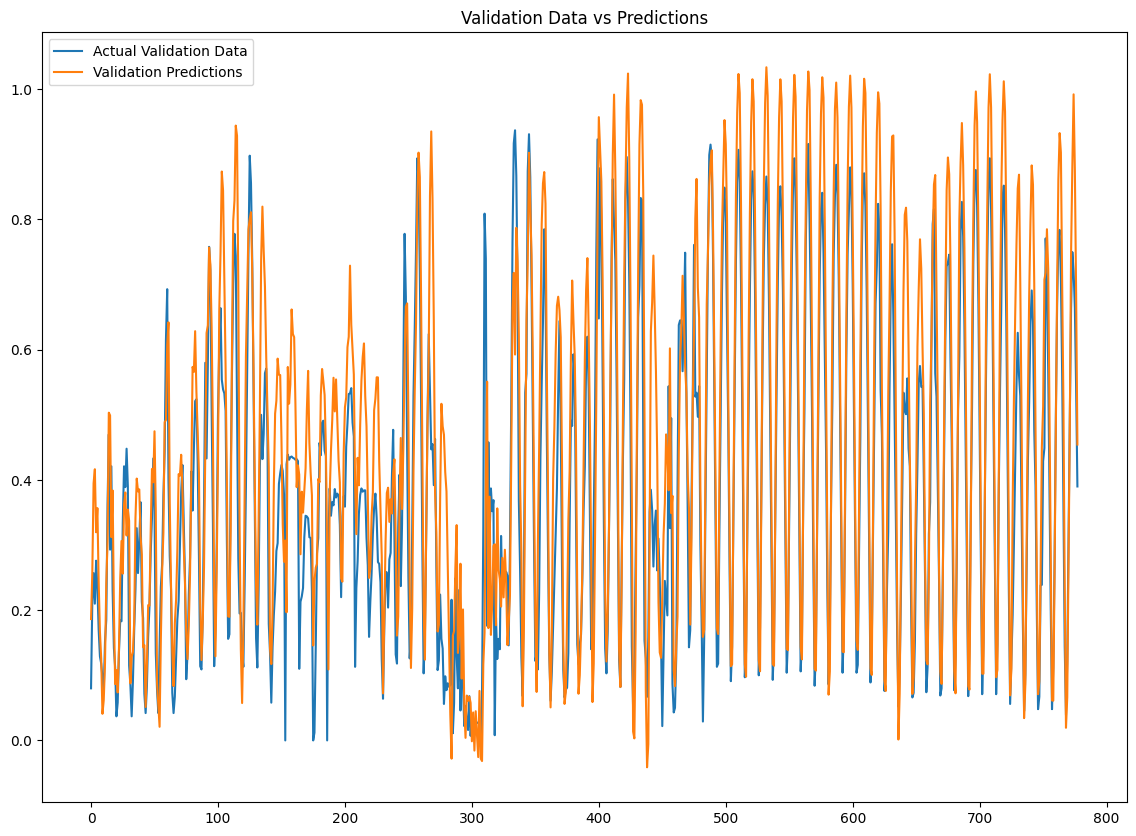

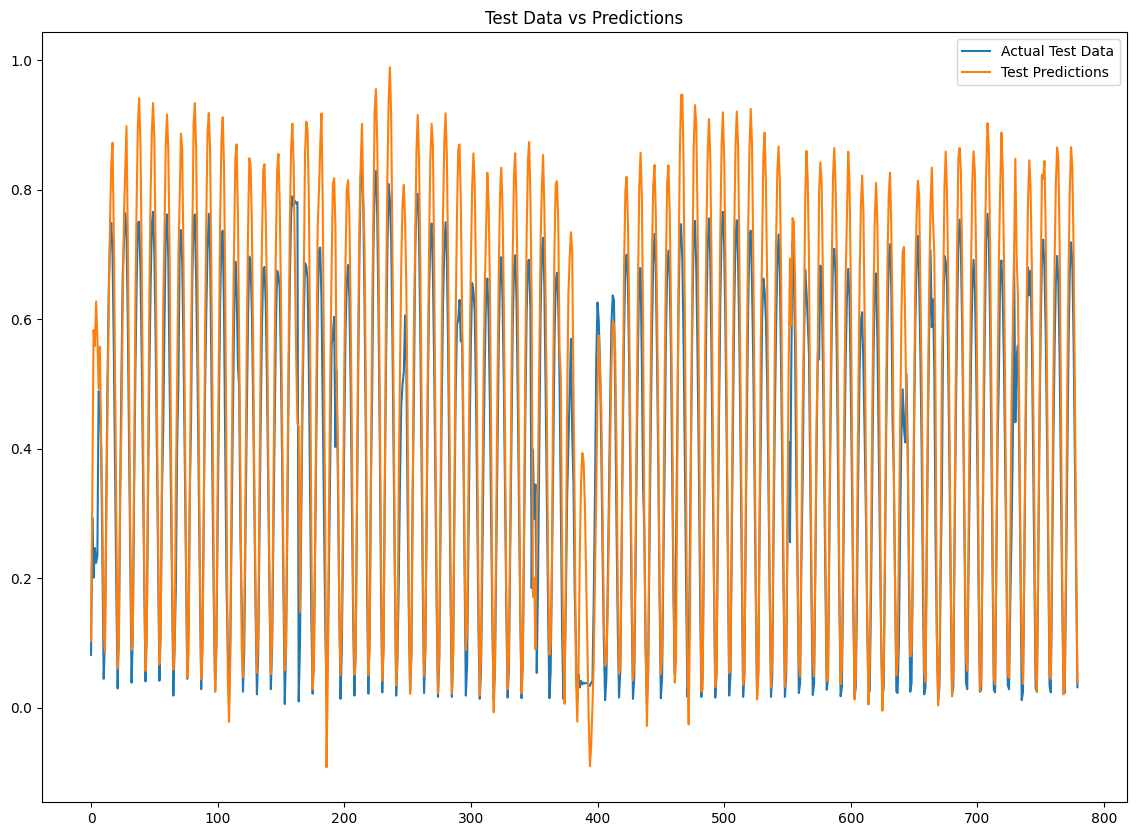

Training - MSE: 0.0092, RMSE: 0.0959, MAE: 0.0635, R^2: 0.8745
Validation - MSE: 0.0192, RMSE: 0.1385, MAE: 0.1094, R^2: 0.6808
Testing - MSE: 0.0156, RMSE: 0.1249, MAE: 0.0995, R^2: 0.7384


In [ ]:

# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Colab_Notebooks/Irradiance_Data_23_Copy.xlsx'  # Update this path
df = pd.read_excel(file_path)

# Clean the data
df = df[['Date / Time', 'irradiance']]
df.dropna(inplace=True)
df.set_index('Date / Time', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)

# Function to create sequences for time series data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length and split data into train, validation, and test sets
seq_length = 24
train_size = int(len(df_normalized) * 0.6)
val_size = int(len(df_normalized) * 0.2)
test_size = len(df_normalized) - train_size - val_size

train_data = df_normalized[:train_size]
val_data = df_normalized[train_size:train_size + val_size]
test_data = df_normalized[train_size + val_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Transform the input data to have the correct input size (64)
def transform_input(X, input_size):
    transformed_X = np.zeros((X.shape[0], X.shape[1], input_size))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            transformed_X[i, j, 0] = X[i, j]
    return transformed_X

input_size = 64
X_train = transform_input(X_train, input_size)
X_val = transform_input(X_val, input_size)
X_test = transform_input(X_test, input_size)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Define Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, seq_length, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

# Initialize the model
seq_length = 24
nhead = 2
num_layers = 2
model = TransformerModel(input_size, seq_length, nhead, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plotting the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Making predictions
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor).numpy()
    val_predictions = model(X_val_tensor).numpy()
    test_predictions = model(X_test_tensor).numpy()

# Inverse scaling
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_val = scaler.inverse_transform(y_val)
y_test = scaler.inverse_transform(y_test)

# Plotting predictions
plt.figure(figsize=(14, 10))
plt.plot(y_train, label='Actual Train Data')
plt.plot(train_predictions, label='Train Predictions')
plt.legend()
plt.title('Train Data vs Predictions')
plt.show()

plt.figure(figsize=(14, 10))
plt.plot(y_val, label='Actual Validation Data')
plt.plot(val_predictions, label='Validation Predictions')
plt.legend()
plt.title('Validation Data vs Predictions')
plt.show()

plt.figure(figsize=(14, 10))
plt.plot(y_test, label='Actual Test Data')
plt.plot(test_predictions, label='Test Predictions')
plt.legend()
plt.title('Test Data vs Predictions')
plt.show()

# Calculate metrics
def calculate_metrics(actual, predicted, name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    print(f'{name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')

calculate_metrics(y_train, train_predictions, 'Training')
calculate_metrics(y_val, val_predictions, 'Validation')
calculate_metrics(y_test, test_predictions, 'Testing')
